### Cats vs Dogs classification using a pretrained convnet(VGG16) with the method of fine tunning

In this case the VGG16 is build in 5 blocks the first 4 of those will be frozen
the 5th one will be adjusted and on top a fully connected classifier is connected

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_physical_devices('GPU')

#configure the GPU(s), to use the memory necessary up to the GPU max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
            print(tf.config.experimental.get_device_details(gpu))
        logi_gpu=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),'Physical GPU(s)',len(logi_gpu),'Logical GPU(s)')
        
    except RuntimeError as e:
        print(e)
print("Is gpu available?, :",tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

Num GPUs Available:  1
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}
1 Physical GPU(s) 1 Logical GPU(s)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is gpu available?, : True


In [2]:
#import the pretrained model
from keras.applications import VGG16
conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
#all layers up to block4_pool should be frozen
set_trainable=False
for layer in conv_base.layers:
    if layer.name=="block5_conv1":
        set_trainable=True
    layer.trainable=set_trainable

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [4]:
#defying the model
from keras import models,layers,optimizers

model=models.Sequential()
model.add(conv_base)#adding the pretrained conv base
model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [5]:
#fine-tuning the model
from keras.preprocessing.image import ImageDataGenerator

train_aug=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,fill_mode="nearest")
                            #data augmentation technique

train_g_aug=train_aug.flow_from_directory("CatsvsDogs_small_dataset\Train",
                                        target_size=(150,150),
                                        batch_size=20,
                                        class_mode="binary")
                                        #creating the generator

val_d=ImageDataGenerator(rescale=1./255)
val_g=val_d.flow_from_directory("CatsvsDogs_small_dataset\Validation",
                                target_size=(150,150),batch_size=20,
                                class_mode="binary")
                                    
test_d=ImageDataGenerator(rescale=1./255)
test_g=test_d.flow_from_directory("CatsvsDogs_small_dataset\Test",
                                target_size=(150,150),batch_size=20,
                                class_mode="binary")
model.compile(loss="binary_crossentropy",
               optimizer=optimizers.RMSprop(lr=1e-5),
               metrics=["acc"])
history=model.fit(train_g_aug,
                          epochs=100,
                          steps_per_epoch=100,
                          validation_data=val_g,
                          validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\simon\.conda\envs\deep_learning_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
100/100 [==============================] - 33s 251ms/step - loss: 0.5408 - acc: 0.7220 - val_loss: 0.3536 - val_acc: 0.8550
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - loss: 0.3609 - acc: 0.8335 - val_loss: 0.3266 - val_acc: 0.8490
Epoch 3/100
100/100 [==============================] - 12s 120ms/step - loss: 0.3102 - acc: 0.8590 - val_loss: 0.2836 - val_acc: 0.8730
Epoch 4/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2770 - acc: 0.8775 - val_loss: 0.2372 - val_acc: 0.9000
Epoch 5/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2597 - acc: 0.8895 - val_loss: 0.2243 - val_acc: 0.9090
Epoch 6/100
100/100 [==============================] - 12s 123ms/step - loss: 0.2390 - acc: 0.8985 - val_loss: 0.2478 - val_acc: 0.9040
Epoch 7/100
100/100 [==============================] - 14s 135ms/step - loss: 0.2088 - acc: 0.9110 - val_loss: 0.2277 - val_acc: 0.9130
Epoch 8/100
100/100 [===========================

50/50 [==============================] - 3s 51ms/step - loss: 0.3826 - acc: 0.9350
Test accuracy: 0.94


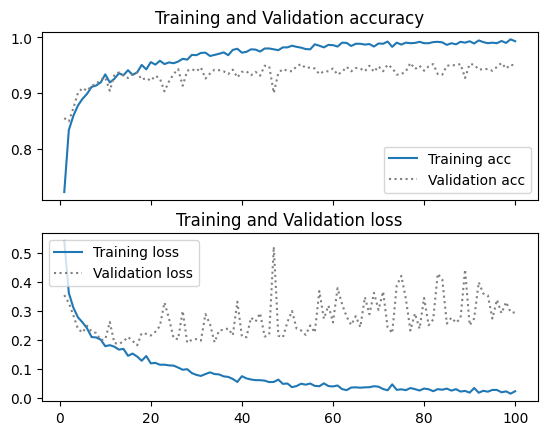

In [10]:
#ploting the results
import matplotlib.pyplot as plt
acc=history.history["acc"]
val_acc=history.history["val_acc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(acc)+1)
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,acc,label="Training acc")
ax1.plot(epochs,val_acc,ls=":",color="gray",label="Validation acc")
ax1.legend()
ax1.set_title("Training and Validation accuracy")

ax2.plot(epochs,loss,label="Training loss")
ax2.plot(epochs,val_loss,color="gray",ls=":",label="Validation loss")
ax2.legend()
ax2.set_title("Training and Validation loss")
test_loss,test_acc=model.evaluate(test_g)
print("Test accuracy: {:.2f}".format(test_acc))

50/50 [==============================] - 3s 50ms/step - loss: 0.3826 - acc: 0.9350
Test accuracy: 0.94


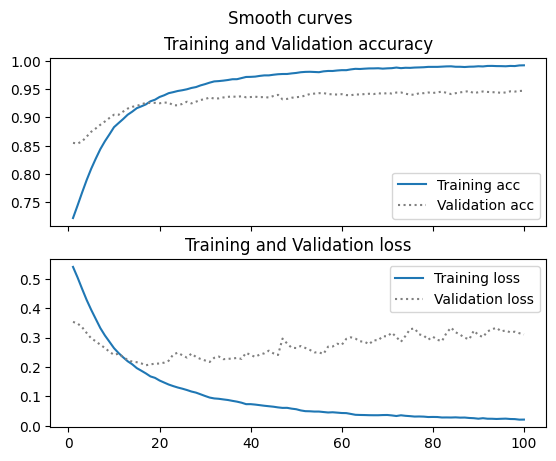

In [11]:
#smoothing the plot to make them more readable
def smooth_curve(points,factor=0.8):
    smooth_points=[]
    for point in points:
        if smooth_points:
            pre=smooth_points[-1]
            smooth_points.append(pre*factor+point*(1-factor))
        else:
            smooth_points.append(point)
    return smooth_points

f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle("Smooth curves")
ax1.plot(epochs,smooth_curve(acc),label="Training acc")
ax1.plot(epochs,smooth_curve(val_acc),
         ls=":",color="gray",label="Validation acc")
ax1.legend()
ax1.set_title("Training and Validation accuracy")

ax2.plot(epochs,smooth_curve(loss),label="Training loss")
ax2.plot(epochs,smooth_curve(val_loss),
         color="gray",ls=":",label="Validation loss")
ax2.legend()
ax2.set_title("Training and Validation loss")
test_loss,test_acc=model.evaluate(test_g)
print("Test accuracy: {:.2f}".format(test_acc))

1/1 [==============================] - 0s 152ms/step


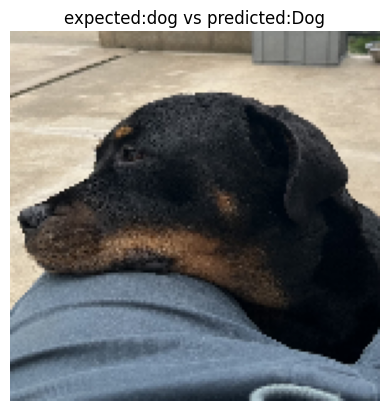

In [7]:
#testing model prediction with my dog's picture
import cv2
import matplotlib.pyplot as plt
img_t=cv2.imread("mine.jpg",cv2.IMREAD_COLOR)
img_t=cv2.cvtColor(img_t,cv2.COLOR_BGR2RGB)
img_t=img=cv2.resize(img_t,(150,150))
def get_key(dic,item):
    item=int(item)
    for key,value in dic.items():
        if value==item:
            return key
    return None

dic={"Cat":0,"Dog":1}        

plt.imshow(img_t)

label_pre=model.predict(img_t.reshape((1,)+img_t.shape))

plt.title("expected:dog vs predicted:{}".
          format(get_key(dic,label_pre[0][0])))
plt.axis("off")
plt.show()

In [12]:
#save the model
model.save("CatsvsDogs_pretrained_fine_tunning.h5")